In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pd.set_option('display.width', 256)

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [8]:
all_data = pd.concat([train_data, test_data])

In [9]:
train_data.shape,test_data.shape,all_data.shape

((891, 12), (418, 11), (1309, 12))

In [21]:
train_data[(train_data.Sex =='male')&(train_data.Ticket!=None)].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [22]:
print("===== survived by class and sex")
print(train_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))

===== survived by class and sex
Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64


In [25]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]

print("===== train: males")
print(train_data[train_data["Sex"] == "male"][describe_fields].describe())

print("===== test: males")
print(test_data[test_data["Sex"] == "male"][describe_fields].describe())

print("===== train: females")
print(train_data[train_data["Sex"] == "female"][describe_fields].describe())

print("===== test: females")
print(test_data[test_data["Sex"] == "female"][describe_fields].describe())

===== train: males
              Age        Fare      Pclass       SibSp       Parch
count  453.000000  577.000000  577.000000  577.000000  577.000000
mean    30.726645   25.523893    2.389948    0.429809    0.235702
std     14.678201   43.138263    0.813580    1.061811    0.612294
min      0.420000    0.000000    1.000000    0.000000    0.000000
25%     21.000000    7.895800    2.000000    0.000000    0.000000
50%     29.000000   10.500000    3.000000    0.000000    0.000000
75%     39.000000   26.550000    3.000000    0.000000    0.000000
max     80.000000  512.329200    3.000000    8.000000    5.000000
===== test: males
              Age        Fare      Pclass       SibSp       Parch
count  205.000000  265.000000  266.000000  266.000000  266.000000
mean    30.272732   27.527877    2.334586    0.379699    0.274436
std     13.389528   41.079423    0.808497    0.843735    0.883745
min      0.330000    0.000000    1.000000    0.000000    0.000000
25%     22.000000    7.854200    2.0000

In [26]:
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None

def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"


data_digest = DataDigest()
data_digest.ages = all_data.groupby("Sex")["Age"].median()
data_digest.fares = all_data.groupby("Pclass")["Fare"].median()
data_digest.titles = pd.Index(test_data["Name"].apply(get_title).unique())
data_digest.families = pd.Index(test_data.apply(get_family, axis=1).unique())
data_digest.cabins = pd.Index(test_data["Cabin"].fillna("unknown").unique())
data_digest.tickets = pd.Index(test_data["Ticket"].fillna("unknown").unique())

In [33]:
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def munge_data(data, digest):
    # Age - замена пропусков на медиану в зависимости от пола
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    # Fare - замена пропусков на медиану в зависимости от класса
    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    # Gender - замена
    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))

    # Gender - расширение
    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    # Embarkment - замена
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    # Embarkment - расширение
    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    # Количество родственников на борту
    data["RelativesF"] = data["Parch"] + data["SibSp"]

    # Человек-одиночка?
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    # Deck - замена
    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))

    # Deck - расширение
    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    # Titles - расширение
    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)

    # амена текстов на индекс из соответствующего справочника или -1 если значения в справочнике нет (расширять не будем)
    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))

    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))

    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))

    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    # для статистики
    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data

In [34]:
train_data_munged = munge_data(train_data, data_digest)
test_data_munged = munge_data(test_data, data_digest)
all_data_munged = pd.concat([train_data_munged, test_data_munged])

In [36]:
predictors = ["Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms", 
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"]

In [37]:
scaler = StandardScaler()
scaler.fit(all_data_munged[predictors])

train_data_scaled = scaler.transform(train_data_munged[predictors])
test_data_scaled = scaler.transform(test_data_munged[predictors])

In [39]:
print("===== survived by age")
print(train_data_munged.groupby(["AgeR"])["Survived"].value_counts(normalize=True))

print("===== survived by gender and age")
print(train_data_munged.groupby(["Sex", "AgeR"])["Survived"].value_counts(normalize=True))

print("===== survived by class and age")
print(train_data_munged.groupby(["Pclass", "AgeR"])["Survived"].value_counts(normalize=True))

===== survived by age
AgeR      Survived
(0, 5]    1           0.704545
          0           0.295455
(10, 15]  1           0.578947
          0           0.421053
(15, 20]  0           0.656250
          1           0.343750
(20, 25]  0           0.655738
          1           0.344262
(25, 30]  0           0.611111
          1           0.388889
(30, 40]  0           0.554839
          1           0.445161
(40, 50]  0           0.616279
          1           0.383721
(5, 10]   0           0.650000
          1           0.350000
(50, 60]  0           0.595238
          1           0.404762
(60, 70]  0           0.764706
          1           0.235294
(70, 80]  0           0.800000
          1           0.200000
Name: Survived, dtype: float64
===== survived by gender and age
Sex     AgeR      Survived
female  (0, 5]    1           0.761905
                  0           0.238095
        (10, 15]  1           0.750000
                  0           0.250000
        (15, 20]  1           

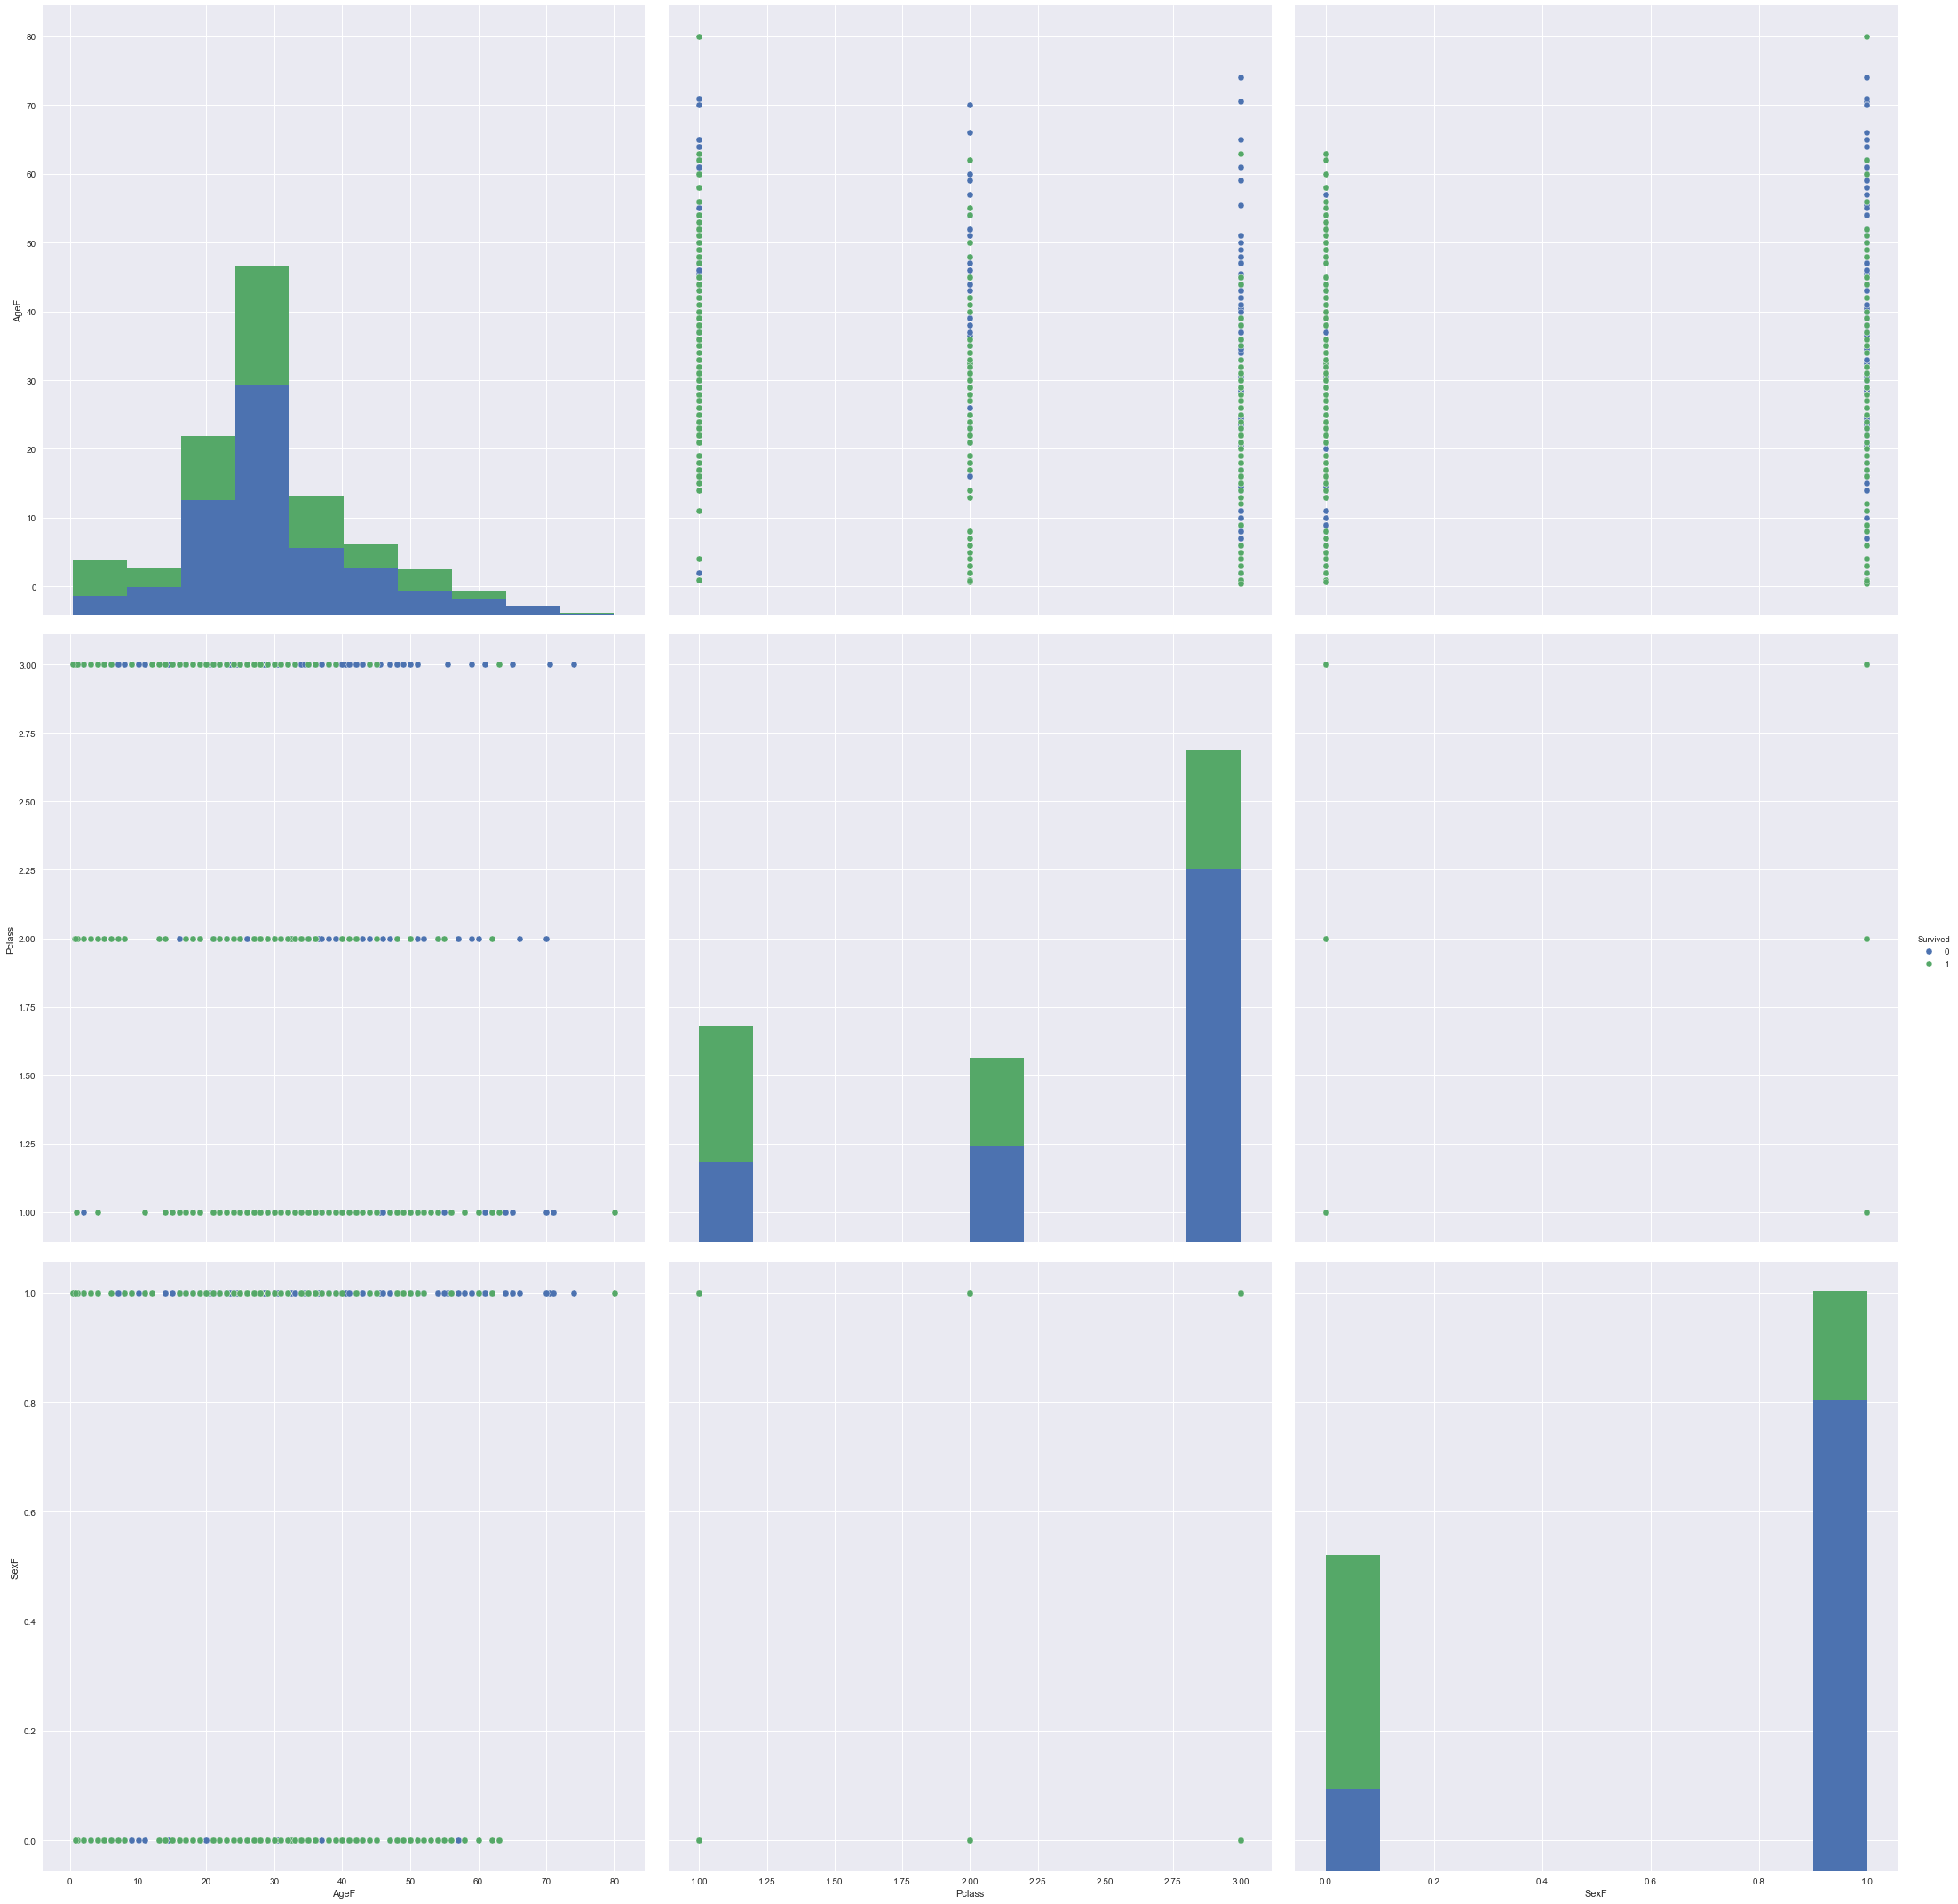

In [60]:
sns.pairplot(train_data_munged, vars=["AgeF", "Pclass", "SexF"], hue="Survived", dropna=True,size=10)
sns.plt.show()

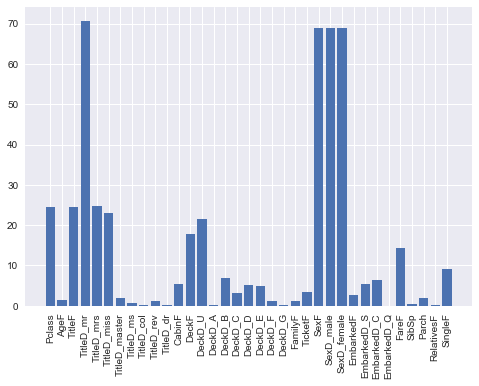

In [44]:
selector = SelectKBest(f_classif, k=5)
selector.fit(train_data_munged[predictors], train_data_munged["Survived"])

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [45]:
cv = StratifiedKFold(train_data["Survived"], n_folds=3, shuffle=True, random_state=1)

In [46]:
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(alg_ngbh, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (k-neighbors): {}/{}".format(scores.mean(), scores.std()))

Accuracy (k-neighbors): 0.795735129068/0.0111105442611


In [47]:
alg_sgd = SGDClassifier(random_state=1)
scores = cross_val_score(alg_sgd, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (sgd): {}/{}".format(scores.mean(), scores.std()))

Accuracy (sgd): 0.723905723906/0.0153066012312


In [48]:
alg_svm = SVC(C=1.0)
scores = cross_val_score(alg_svm, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (svm): {}/{}".format(scores.mean(), scores.std()))

Accuracy (svm): 0.819304152637/0.0104081015662


In [49]:
alg_nbs = GaussianNB()
scores = cross_val_score(alg_nbs, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (naive bayes): {}/{}".format(scores.mean(), scores.std()))

Accuracy (naive bayes): 0.620650953984/0.163391237085


In [50]:
def linear_scorer(estimator, x, y):
    scorer_predictions = estimator.predict(x)

    scorer_predictions[scorer_predictions > 0.5] = 1
    scorer_predictions[scorer_predictions <= 0.5] = 0

    return metrics.accuracy_score(y, scorer_predictions)

alg_lnr = LinearRegression()
scores = cross_val_score(alg_lnr, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (linear regression): {}/{}".format(scores.mean(), scores.std()))

Accuracy (linear regression): 0.812570145903/0.00965468604606


In [51]:
alg_log = LogisticRegression(random_state=1)
scores = cross_val_score(alg_log, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (logistic regression): {}/{}".format(scores.mean(), scores.std()))

Accuracy (logistic regression): 0.81593714927/0.0123965892449


In [52]:
alg_frst = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
scores = cross_val_score(alg_frst, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (random forest): {}/{}".format(scores.mean(), scores.std()))

Accuracy (random forest): 0.829405162738/0.00419939100648


In [53]:
alg_frst_model = RandomForestClassifier(random_state=1)
alg_frst_params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_frst_grid.fit(train_data_scaled, train_data_munged["Survived"])
alg_frst_best = alg_frst_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.6min finished


Accuracy (random forest auto): 0.837261503928 with params {'min_samples_split': 6, 'n_estimators': 400, 'min_samples_leaf': 4}


In [55]:
ald_xgb_model = xgb.XGBClassifier()
ald_xgb_params = [
    {"n_estimators": [230, 250, 270],
     "max_depth": [1, 2, 4],
     "learning_rate": [0.01, 0.02, 0.05]}
]
alg_xgb_grid = GridSearchCV(ald_xgb_model, ald_xgb_params, cv=cv, refit=True, verbose=1)
alg_xgb_grid.fit(train_data_scaled, train_data_munged["Survived"])
alg_xgb_best = alg_xgb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   14.1s finished


Accuracy (xgboost auto): 0.833894500561 with params {'n_estimators': 270, 'learning_rate': 0.02, 'max_depth': 2}
